In [47]:
import sys, os
DMOL_DIR = "../"
sys.path.append(os.path.join(DMOL_DIR, "utils"))
from ml_utils import *

import numpy as np
import pandas as pd
import math
import pickle
from itertools import combinations
pd.options.display.max_columns = 999
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from astropy.stats import median_absolute_deviation
from sklearn.pipeline import Pipeline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../data/class_data.csv")
df_proc = preprocess_df(df, verbose = False)

In [3]:
def get_metrics(y_true, y_pred, k):
    print("MSE:  {}".format(mean_squared_error(y_true, y_pred)))
    print("MAE:  {}".format(mean_absolute_error(y_true, y_pred)))
    R = r2_score(y_true, y_pred)
    n = len(y_true)
    adjR = 1 - (1-R**2)*(n-1) / (n-k-1)
    print("r-squared:  {}".format(R))
    print("Adjusted r-squared:  {}".format(adjR))

def mad_remove_outlier(df):
    for i, c in enumerate(list(df.columns)):
        mad, mu = median_absolute_deviation(df[c]), df[c].mean()
        for idx in df.index:
            if df.loc[idx, c] > mu + 3 * mad:
                df.loc[idx, c] = mu + 3 * mad
            elif df.loc[idx, c] < mu - 3 * mad:
                df.loc[idx, c] = mu - 3 * mad
    return df
        

### Quiz Distr

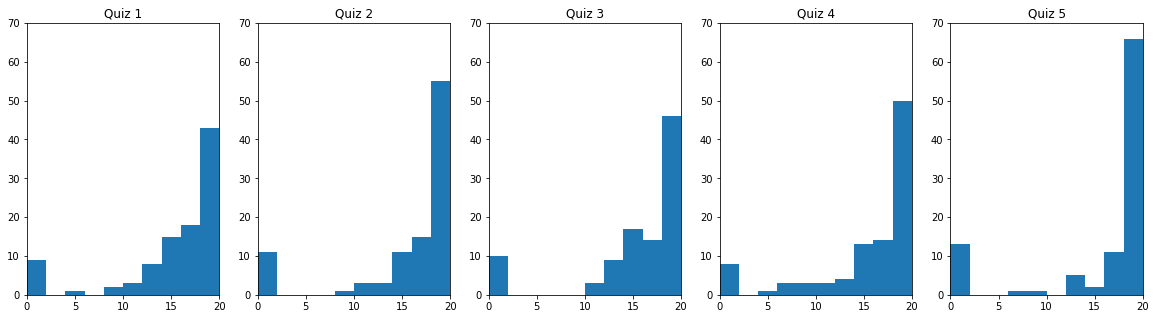

In [4]:
fig, ax = plt.subplots(1, 5, figsize = (20, 5))
for i in range(1, 6):
    plt.subplot(1, 5, i)
    plt.hist(df_proc["gr_revq{}".format(i)])
    plt.title("Quiz {}".format(i), fontsize = 12)
    plt.xlim((0, 20))
    plt.ylim(0, 70)

Text(0.5,1,'Above B+')

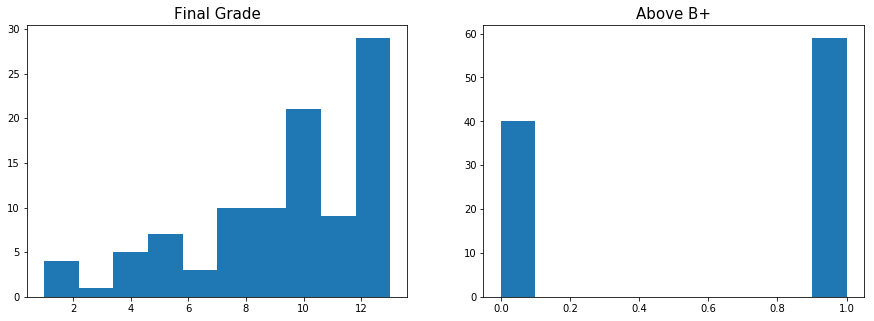

In [5]:
plt.subplots(1, 2, figsize = (15, 5))
plt.subplot(1, 2, 1)
final_grade = df_proc["gr_gradef"].map(grade_scale_map)
final_grade = final_grade.fillna(final_grade.median())
plt.hist(final_grade)
plt.title("Final Grade", fontsize = 15)
plt.subplot(1, 2, 2)
df_proc["gr_aboveB+"] =  pd.DataFrame(final_grade >= 10)["gr_gradef"].map({False: 0, True: 1})
plt.hist(df_proc["gr_aboveB+"])
plt.title("Above B+", fontsize = 15)

Final Grade Null Percentage:  6.0606060606060606%
pre_wgrade Null Percentage:  0.0%
pre_egrade Null Percentage:  0.0%
pre_badgrade Null Percentage:  0.0%


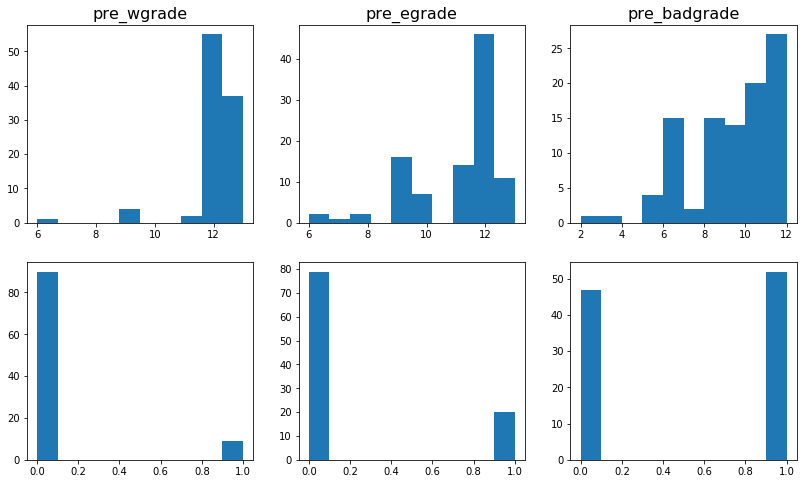

In [6]:
fig, ax = plt.subplots(2, 3, figsize = (13.8, 8))
print("{} Null Percentage:  {}%".format("Final Grade", df_proc[df_proc["gr_gradef"].isna()].shape[0] / df_proc.shape[0] * 100))
for i, col in enumerate(["pre_wgrade", "pre_egrade", "pre_badgrade"]):
    plt.subplot(2, 3, i+1)
    grades = df_proc[col]
    print("{} Null Percentage:  {}%".format(col, df_proc[df_proc[col].isna()].shape[0] / df_proc.shape[0] * 100))
    plt.hist(grades)
    plt.title(col, size = 16)
    plt.subplot(2, 3, i+4)
    plt.hist(pd.DataFrame(final_grade > grades)[0].map({False: 0, True: 1}))

In [7]:
df_proc["gr_satisfied"] = pd.DataFrame(final_grade > df_proc["pre_badgrade"])[0].map({False: 0, True: 1})

### Use Quiz Scores to Predict Final Grade

In [22]:
NEW_VAR_MAP['week_1']["Quant"]['Grade Expectations'].remove("pre_wgrade")
NEW_VAR_MAP['week_1']["Quant"]['Grade Expectations']

{'pre_badgrade', 'pre_egrade'}

In [23]:
# for k in ["post_badgrade", "post_badgradef", "post_egradef", "post_wgradef"]:
#     NEW_VAR_MAP['post']["Quant"]['Grade Expectations'].remove(k)
NEW_VAR_MAP['post']["Quant"]['Grade Expectations']

{'post_egrade', 'post_egrade_let', 'post_wgrade'}

In [26]:
NEW_VAR_MAP['week_1']["Quant"]['Demographics']

{'post_sex',
 'pre_begscl',
 'pre_cong',
 'pre_eng1st',
 'pre_parents',
 'pre_resid'}

In [28]:
df_proc.shape

(99, 1353)

#### Predict Final Score (reg)

In [37]:
trained_models, testing_scores = [], []
for week in range(1, 6):
    var_names = list(NEW_VAR_MAP['week_1']["Quant"]['Demographics']) + ["gr_revq{}".format(i) for i in range(1, week+1)]
    X = df_proc[var_names].copy()
    y = df_proc["gr_revqf"]
    X, y = X.fillna(X.median()), y.fillna(y.median())
    reg =  Pipeline([("scaler", StandardScaler()), 
                     ('reg', RandomForestRegressor(random_state = 42, n_jobs = 8))])
#     param_grid = [{'reg__criterion': ['mse', 'mae'], 'reg__n_estimators': [10, 15],
#                    'reg__max_depth': [5, 10]}] 
    param_grid = [{'reg__criterion': ['mse', 'mae'], 'reg__n_estimators': [50, 100, 150, 200, 300],
                   'reg__max_depth': [5, 10, 15, 20, 50, 80, 120]}] 
    model = GridSearchCV(reg, param_grid, cv = 3, scoring = "r2", return_train_score=True)
    model.fit(X, y)
    trained_models.append(model)
    print("Up to Week {}".format(week))
    print("Variables used: {}".format(var_names))
    print("Found Best Params:  {}\n".format(model.best_params_))
    print("Training Score with Best Params:  {}".format(model.cv_results_['mean_train_score'][model.best_index_]))
    print("Testing Score with Best Params:  {}\n".format(model.cv_results_['mean_test_score'][model.best_index_]))
    testing_scores.append(model.cv_results_['mean_test_score'][model.best_index_])
    print("Overall Specs: ")
    get_metrics(model.predict(X), y, X.shape[1]); print('\n')

Up to Week 1
Variables used: ['pre_eng1st', 'post_sex', 'pre_resid', 'pre_parents', 'pre_cong', 'pre_begscl', 'gr_revq1']
Found Best Params:  {'reg__criterion': 'mae', 'reg__max_depth': 5, 'reg__n_estimators': 150}

Training Score with Best Params:  0.6145561535461076
Testing Score with Best Params:  -0.045346596249697536

Overall Specs: 
MSE:  89.86748544472502
MAE:  5.461405723905724
r-squared:  -1.8342069219188555
Adjusted r-squared:  3.546185419523892


Up to Week 2
Variables used: ['pre_eng1st', 'post_sex', 'pre_resid', 'pre_parents', 'pre_cong', 'pre_begscl', 'gr_revq1', 'gr_revq2']
Found Best Params:  {'reg__criterion': 'mae', 'reg__max_depth': 5, 'reg__n_estimators': 300}

Training Score with Best Params:  0.7178147639902875
Testing Score with Best Params:  0.14770726744426108

Overall Specs: 
MSE:  54.920869677679576
MAE:  4.457680976430977
r-squared:  0.0767016918464416
Adjusted r-squared:  -0.08248279273170622


Up to Week 3
Variables used: ['pre_eng1st', 'post_sex', 'pre_re

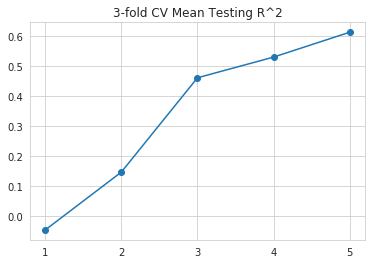

In [69]:
def plot_testing_scores(testing_scores, title):
    plt.plot(testing_scores, '-o')
    sns.set_style("whitegrid")
    plt.xticks(list(range(5)), list(range(1, 6)))
    plt.title(title)
    plt.show()
    
plot_testing_scores(testing_scores, "3-fold CV Mean Testing R^2")

In [54]:
# pickle.dump(trained_models, open("quiz_models.pkl", 'wb'))

In [66]:
def get_feature_importance(trained_models, step_name):
    feature_importance_master = pd.DataFrame()
    for i, model in enumerate(trained_models):
        var_names = list(NEW_VAR_MAP['week_1']["Quant"]['Demographics']) + ["gr_revq{}".format(i) for i in range(1, i+2)]
        df_feature_imp = pd.DataFrame(model.best_estimator_.named_steps[step_name].feature_importances_, 
                                  index=  var_names, columns = ["up_to_week_{}".format(i+1)])
        feature_importance_master = pd.concat([master, df_feature_imp], axis = 1)
    display(feature_importance_master)
    
get_feature_importance(trained_models, "reg")

,up_to_week_1,up_to_week_2,up_to_week_3,up_to_week_4,up_to_week_5,up_to_week_5
gr_revq1,0.390491,0.295518,0.191483,0.128154,0.123469,0.123469
gr_revq2,NaN,0.380196,0.207594,0.115893,0.123945,0.123945
gr_revq3,NaN,NaN,0.344199,0.242987,0.187748,0.187748
gr_revq4,NaN,NaN,NaN,0.369527,0.261657,0.261657
gr_revq5,NaN,NaN,NaN,NaN,0.142815,0.142815
post_sex,0.048816,0.025140,0.021749,0.014809,0.011745,0.011745
pre_begscl,0.173151,0.094051,0.065624,0.039788,0.039611,0.039611
pre_cong,0.064077,0.046268,0.022710,0.011531,0.018036,0.018036
pre_eng1st,0.063719,0.031959,0.027191,0.012628,0.017538,0.017538
pre_parents,0.088792,0.053554,0.051998,0.031296,0.039593,0.039593


#### Predict Final Grade above B+ (Binary Classification)

In [67]:
def predict_final_letter_bin(y_col):
    trained_models, testing_scores = [], []
    for week in range(1, 6):
        var_names = list(NEW_VAR_MAP['week_1']["Quant"]['Demographics']) + ["gr_revq{}".format(i) for i in range(1, week+1)]
        X = df_proc[var_names].copy()
        y = df_proc[y_col]
        X, y = X.fillna(X.median()), y.fillna(y.median())
        clf =  Pipeline([("scaler", StandardScaler()), 
                         ('clf', RandomForestClassifier(random_state = 42, n_jobs = 8, class_weight = "balanced"))])
#         param_grid = [{'clf__criterion': ['gini', 'entropy'], 'clf__n_estimators': [10, 15],
#                    'clf__max_depth': [5, 10]}] 
        param_grid = [{'clf__criterion': ['gini', 'entropy'], 'clf__n_estimators': [50, 100, 150, 200, 300],
                       'clf__max_depth': [5, 10, 15, 20, 50, 80, 120]}] 
        model = GridSearchCV(clf, param_grid, cv = 3, scoring = "f1_macro", return_train_score=True)
        model.fit(X, y)
        trained_models.append(model)
        print("Up to Week {}".format(week))
        print("Variables used: {}".format(var_names))
        print("Found Best Params:  {}\n".format(model.best_params_))
        print("Training Score with Best Params:  {}".format(model.cv_results_['mean_train_score'][model.best_index_]))
        print("Testing Score with Best Params:  {}\n".format(model.cv_results_['mean_test_score'][model.best_index_]))
        testing_scores.append(model.cv_results_['mean_test_score'][model.best_index_])
    return trained_models, testing_scores

In [68]:
trained_models_bplus, testing_scores_bplus = predict_final_letter_bin("gr_aboveB+")

Up to Week 1
Variables used: ['pre_eng1st', 'post_sex', 'pre_resid', 'pre_parents', 'pre_cong', 'pre_begscl', 'gr_revq1']
Found Best Params:  {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__n_estimators': 50}

Training Score with Best Params:  0.8814721552461693
Testing Score with Best Params:  0.5661253741025972

Up to Week 2
Variables used: ['pre_eng1st', 'post_sex', 'pre_resid', 'pre_parents', 'pre_cong', 'pre_begscl', 'gr_revq1', 'gr_revq2']
Found Best Params:  {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__n_estimators': 150}

Training Score with Best Params:  0.9295023553598268
Testing Score with Best Params:  0.6525520775520776

Up to Week 3
Variables used: ['pre_eng1st', 'post_sex', 'pre_resid', 'pre_parents', 'pre_cong', 'pre_begscl', 'gr_revq1', 'gr_revq2', 'gr_revq3']
Found Best Params:  {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__n_estimators': 150}

Training Score with Best Params:  0.9463993524846179
Testing Score with Best Params:  0.62140452

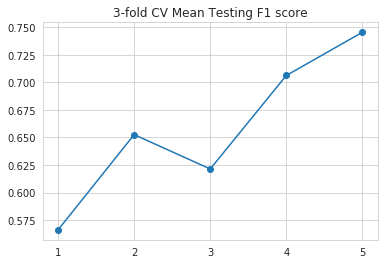

In [74]:
plot_testing_scores(testing_scores_bplus, "3-fold CV Mean Testing F1 score")

In [75]:
get_feature_importance(trained_models_bplus, "clf")

,up_to_week_1,up_to_week_2,up_to_week_3,up_to_week_4,up_to_week_5,up_to_week_5
gr_revq1,0.390491,0.295518,0.191483,0.128154,0.123469,0.128372
gr_revq2,NaN,0.380196,0.207594,0.115893,0.123945,0.129834
gr_revq3,NaN,NaN,0.344199,0.242987,0.187748,0.123292
gr_revq4,NaN,NaN,NaN,0.369527,0.261657,0.253445
gr_revq5,NaN,NaN,NaN,NaN,0.142815,0.104730
post_sex,0.048816,0.025140,0.021749,0.014809,0.011745,0.035355
pre_begscl,0.173151,0.094051,0.065624,0.039788,0.039611,0.066648
pre_cong,0.064077,0.046268,0.022710,0.011531,0.018036,0.029645
pre_eng1st,0.063719,0.031959,0.027191,0.012628,0.017538,0.026671
pre_parents,0.088792,0.053554,0.051998,0.031296,0.039593,0.060334


In [ ]:
# pickle.dump(trained_models_bplus, open("quiz_models_bplus.pkl", 'wb'))

#### Predict Final Grade satisfies Worst Grade Expectation (Binary Classification)

In [77]:
trained_models_satisfied, testing_scores_satisfied = predict_final_letter_bin("gr_satisfied")

Up to Week 1
Variables used: ['pre_eng1st', 'post_sex', 'pre_resid', 'pre_parents', 'pre_cong', 'pre_begscl', 'gr_revq1']
Found Best Params:  {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__n_estimators': 100}

Training Score with Best Params:  0.9234236127954295
Testing Score with Best Params:  0.6194154493469909

Up to Week 2
Variables used: ['pre_eng1st', 'post_sex', 'pre_resid', 'pre_parents', 'pre_cong', 'pre_begscl', 'gr_revq1', 'gr_revq2']
Found Best Params:  {'clf__criterion': 'gini', 'clf__max_depth': 15, 'clf__n_estimators': 100}

Training Score with Best Params:  1.0
Testing Score with Best Params:  0.6143779554832686

Up to Week 3
Variables used: ['pre_eng1st', 'post_sex', 'pre_resid', 'pre_parents', 'pre_cong', 'pre_begscl', 'gr_revq1', 'gr_revq2', 'gr_revq3']
Found Best Params:  {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__n_estimators': 300}

Training Score with Best Params:  0.9847538532321142
Testing Score with Best Params:  0.5995157260674727

Up to 

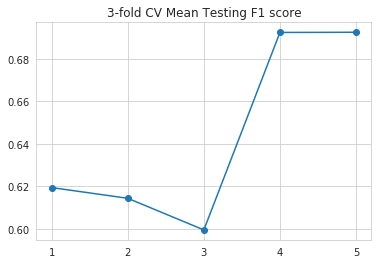

In [78]:
plot_testing_scores(testing_scores_satisfied, "3-fold CV Mean Testing F1 score")

In [79]:
get_feature_importance(trained_models_satisfied, "clf")

,up_to_week_1,up_to_week_2,up_to_week_3,up_to_week_4,up_to_week_5,up_to_week_5
gr_revq1,0.390491,0.295518,0.191483,0.128154,0.123469,0.132350
gr_revq2,NaN,0.380196,0.207594,0.115893,0.123945,0.122867
gr_revq3,NaN,NaN,0.344199,0.242987,0.187748,0.089599
gr_revq4,NaN,NaN,NaN,0.369527,0.261657,0.229027
gr_revq5,NaN,NaN,NaN,NaN,0.142815,0.114481
post_sex,0.048816,0.025140,0.021749,0.014809,0.011745,0.040188
pre_begscl,0.173151,0.094051,0.065624,0.039788,0.039611,0.113551
pre_cong,0.064077,0.046268,0.022710,0.011531,0.018036,0.016419
pre_eng1st,0.063719,0.031959,0.027191,0.012628,0.017538,0.031479
pre_parents,0.088792,0.053554,0.051998,0.031296,0.039593,0.038480


In [81]:
# pickle.dump(trained_models_satisfied, open("quiz_models_satisfied.pkl", 'wb'))

### Model Training (PCA)

In [10]:
def group_construct_var(df, var_map_curr, n_comp = None, verbose = False):
    X = pd.DataFrame()
    pca = KernelPCA(n_components=n_comp, kernel="poly", degree=3) if n_comp is not None else None
    for construct in var_map_curr["Quant"]:
        temp = df[var_map_curr["Quant"][construct]].copy()
        temp = temp.fillna(temp.median())  # use median to fillna
        temp = mad_remove_outlier(temp)    # use mad to remove outliers
        if n_comp is None:
            temp_mean = pd.DataFrame(temp.mean(axis=1))
            temp_mean.columns = ["{}_mean".format(construct)]
            X = pd.concat([X, temp_mean], axis = 1)
        else:
            if len(var_map_curr["Quant"][construct]) < n_comp:
                X = pd.concat([X, temp.copy()], axis = 1)
            else:
                temp_pca = pd.DataFrame(pca.fit_transform(temp))
                temp_pca.columns = ["{}_PC{}".format(construct, i) for i in range(1, n_comp+1)]
                X = pd.concat([X, temp_pca], axis = 1)
                assert(temp_pca.shape[1] == 1)
    return X

def construct_X_y(df, week_num, n_comp, verbose, quiz_week = None):
    var_map_curr = NEW_VAR_MAP["post"] \
                   if week_num == "post" or "clf" else NEW_VAR_MAP["week_{}".format(week_num)] 
    X = group_construct_var(df, var_map_curr, n_comp, verbose)
    y = df["gr_revqf"] if week_num == "post" else df["gr_satisfied"] if week_num == "clf" else df["gr_revq{}".format(week_num)]
    y = y.fillna(y.median())
    week_num = 6 if week_num == "post" or week_num == "clf" else week_num
    quiz_week = list(range(1, week_num)) if quiz_week is None else quiz_week
    for gr in ["gr_revq{}".format(i) for i in quiz_week]:
        X[gr] = df[gr]
    return X, y

In [37]:
def train_model(df, week_num, n_comp = None, quiz_week = None, use_fr = False, plot = False, verbose = False):
    X, y = construct_X_y(df, week_num, n_comp, verbose, quiz_week)

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)

    if week_num != "clf":
        reg =  Pipeline([("scaler", StandardScaler()), 
                         ('reg', RandomForestRegressor(random_state = 42, n_jobs = 8))])

#         param_grid = [{'reg__criterion': ['mse', 'mae'], 'reg__n_estimators': [50, 100, 150, 200, 300],
#                        'reg__max_depth': [5, 10, 15, 20, 50, 80, 120]}] 
        param_grid = [{'reg__criterion': ['mse', 'mae'], 'reg__n_estimators': [10, 15],
                   'reg__max_depth': [5, 10]}] 
        model = GridSearchCV(reg, param_grid, cv = 3, scoring = "neg_mean_squared_error", return_train_score=True)

    else:
        clf =  Pipeline([("scaler", StandardScaler()), 
                         ('clf', RandomForestClassifier(random_state = 42, n_jobs = 8, class_weight = "balanced"))])
        param_grid = [{'clf__criterion': ['gini', 'entropy'], 'clf__n_estimators': [10, 15],
                   'clf__max_depth': [5, 10]}] 
#         param_grid = [{'clf__criterion': ['gini', 'entropy'], 'clf__n_estimators': [50, 100, 150, 200, 300],
#                        'clf__max_depth': [5, 10, 15, 20, 50, 80, 120]}] 
        model = GridSearchCV(clf, param_grid, cv = 3, scoring = "f1_macro", return_train_score=True)
    model.fit(X, y)
    
    print("Found Best Params:  {}\n".format(model.best_params_))
    print("Training Score with Best Params:  {}".format(model.cv_results_['mean_train_score'][model.best_index_]))
    print("Testing Score with Best Params:  {}\n".format(model.cv_results_['mean_test_score'][model.best_index_]))
    print("Overall Specs: ")
    get_metrics(model.predict(X), y, X.shape[1]); print('\n')
    return model, X, y
    

def feature_importance_map(week_num, model, X):
    model_name = "clf" if week_num == 'clf' else "reg"
    df_feature_imp = pd.DataFrame(model.best_estimator_.named_steps[model_name].feature_importances_, 
                                  index=  X.columns, columns = ["week_{}".format(week_num)])
#     df_feature_master = pd.concat([df_feature_master, df_feature_imp], axis=1)
    return df_feature_imp

In [38]:
def check_week_model(week_num, ncomp = 1, quiz_week = None):
    model, X, y = train_model(df_proc, week_num, ncomp, quiz_week)
    df_feature = feature_importance_map(week_num, model, X).sort_values("week_{}".format(week_num), ascending=False)
    display(df_feature)
    return model, df_feature, X, y

In [42]:
model_week1, df_feature_week1, X_week1, y_week1 = check_week_model(1, ncomp = None)

Found Best Params:  {'reg__criterion': 'mse', 'reg__max_depth': 5, 'reg__n_estimators': 15}

Training Score with Best Params:  -15.826353407386916
Testing Score with Best Params:  -26.666723294771696

Overall Specs: 
MSE:  15.97312092024192
MAE:  2.4742012757677934
r-squared:  -0.3864193866881045
Adjusted r-squared:  -0.190952080628225




,week_1
Self-Efficacy_mean,0.217484
Achievement Goals (Mastery approach)_mean,0.147019
Demographics_mean,0.108946
Qualtrics Embedded Data_mean,0.089719
Effort Regulation_mean,0.060299
Activities_mean,0.054225
Internal/External Motivation_mean,0.048483
Cost Value (Loss of Valued Alternatives)_mean,0.039408
Other Activities Time_mean,0.036670
Attainment Value_mean,0.035402


In [41]:
model_week1, df_feature_week1, X_week1, y_week1 = check_week_model(1, ncomp = None)

Found Best Params:  {'reg__criterion': 'mse', 'reg__max_depth': 5, 'reg__n_estimators': 15}

Training Score with Best Params:  -13.691978506678147
Testing Score with Best Params:  -27.03346074337607

Overall Specs: 
MSE:  15.180181174325403
MAE:  2.5159299505992982
r-squared:  -0.40808183747642013
Adjusted r-squared:  -0.1668568994906161




,week_1
Self-Efficacy_PC1,0.185591
Achievement Goals (Mastery approach)_PC1,0.156950
Demographics_PC1,0.128913
Internal/External Motivation_PC1,0.064839
Performance Comparisons_PC1,0.053461
Effort Regulation_PC1,0.038900
Utility Value_PC1,0.038398
Qualtrics Embedded Data_PC1,0.035927
Activities_PC1,0.033125
Consciousness_PC1,0.032177


In [43]:
model_week2, df_feature_week2, X_week2, y_week2 = check_week_model(2, ncomp = 1)

gr_revq1
Found Best Params:  {'reg__criterion': 'mae', 'reg__max_depth': 5, 'reg__n_estimators': 15}

Training Score with Best Params:  -13.876408529741864
Testing Score with Best Params:  -31.971795735129067

Overall Specs: 
MSE:  17.499842873176206
MAE:  2.3831649831649835
r-squared:  -0.22100862015941836
Adjusted r-squared:  -0.3509160666940947




,week_2
gr_revq1,0.271269
Grade Expectations_PC1,0.170866
Activities_PC1,0.130075
Demographics_PC1,0.127223
Cost Value (Outside Effort)_PC1,0.039532
Effort Regulation_PC1,0.034883
Online Self Regulation_PC1,0.031307
Attainment Value_PC1,0.023578
Other Activities Rank_PC1,0.021674
Internal/External Motivation_PC1,0.020635


In [40]:
model_week2, df_feature_week2, X_week2, y_week2 = check_week_model(2, ncomp = None)

gr_revq1
Found Best Params:  {'reg__criterion': 'mae', 'reg__max_depth': 5, 'reg__n_estimators': 15}

Training Score with Best Params:  -14.823771043771044
Testing Score with Best Params:  -29.40618406285073

Overall Specs: 
MSE:  18.653714927048256
MAE:  2.463299663299663
r-squared:  -0.43948103271284045
Adjusted r-squared:  -0.14596999050426418




,week_2
gr_revq1,0.284255
Grade Expectations_mean,0.141192
Activities_mean,0.117115
Demographics_mean,0.088569
Cost Value (Outside Effort)_mean,0.068216
Internal/External Motivation_mean,0.037370
Course Plan_mean,0.033735
Utility Value_mean,0.029502
Attainment Value_mean,0.028536
Achievement Goals (Mastery approach)_mean,0.020636


In [88]:
model_week3, df_feature_week3, X_week3, y_week3 = check_week_model(3, 1)

Found Best Params:  {'reg__criterion': 'mae', 'reg__max_depth': 5, 'reg__n_estimators': 10}

Training Score with Best Params:  -5.221351010101009
Testing Score with Best Params:  -16.948939393939394

Overall Specs: 
MSE:  5.958863636363636
MAE:  1.8904040404040405
r-squared:  0.7144561121186694
Adjusted r-squared:  0.4077019573096916




,week_3
gr_revq2,0.279547
gr_revq1,0.175487
Cost Value (Outside Effort)_PC1,0.121605
Grade Expectations - Quiz_PC1,0.103191
Cost Value (Emotional)_PC1,0.054039
Internal/External Motivation_PC1,0.051920
Other Activities Time_PC1,0.051362
Attainment Value_PC1,0.046756
Demographics_PC1,0.033962
Utility Value_PC1,0.021705


In [94]:
model_week4, df_feature_week4, X_week4, y_week4 = check_week_model(4, 1, [2, 3])

Found Best Params:  {'reg__criterion': 'mse', 'reg__max_depth': 5, 'reg__n_estimators': 15}

Training Score with Best Params:  -4.559437410686105
Testing Score with Best Params:  -15.834197940997763

Overall Specs: 
MSE:  4.825787659041607
MAE:  1.57343022318434
r-squared:  0.7974582327337967
Adjusted r-squared:  0.5483808105010278




,week_4
gr_revq3,0.542376
gr_revq2,0.129342
Utility Value_PC1,0.052859
Reflected Other Activities Time_PC1,0.046080
Grade Expectations - Quiz_PC1,0.039860
Grade Expectations - Course_PC1,0.038543
Grade Expectations - Final_PC1,0.029188
Cost Value (Outside Effort)_PC1,0.022029
Internal/External Motivation_PC1,0.019404
Other Activities Time_PC1,0.019168


In [98]:
model_week5, df_feature_week5, X_week5, y_week5 = check_week_model(5, 1, [3, 4])

Found Best Params:  {'reg__criterion': 'mae', 'reg__max_depth': 10, 'reg__n_estimators': 15}

Training Score with Best Params:  -5.342514029180697
Testing Score with Best Params:  -23.89836139169472

Overall Specs: 
MSE:  5.808170594837263
MAE:  1.2734006734006733
r-squared:  0.8151607084292297
Adjusted r-squared:  0.5889965511943834




,week_5
gr_revq4,0.444873
gr_revq3,0.141297
Grade Expectations - Course_PC1,0.064580
Satisfaction for Activity_PC1,0.064092
Grade Expectations - Final_PC1,0.054443
Utility Value_PC1,0.051850
Internal/External Motivation_PC1,0.038419
Other Activities Time_PC1,0.028673
Cost Value (Emotional)_PC1,0.021845
Cost Value (Outside Effort)_PC1,0.020603


In [101]:
model_week_post, df_feature_week_post, X_week_post, y_week_post = check_week_model("post", 1, [4, 5])

Found Best Params:  {'reg__criterion': 'mae', 'reg__max_depth': 10, 'reg__n_estimators': 15}

Training Score with Best Params:  -45.33016799943883
Testing Score with Best Params:  -128.99591400112234

Overall Specs: 
MSE:  41.97136293490461
MAE:  3.1881313131313136
r-squared:  0.5443388660896049
Adjusted r-squared:  -0.014148963069114062




,week_post
gr_revq4,0.290378
gr_revq5,0.101742
Activities_PC1,0.088815
Grade Expectations_PC1,0.049336
Demographics_PC1,0.046774
Achievement Goals (Performance avoid)_PC1,0.036200
Qualtrics Embedded Data_PC1,0.035973
Cost Value (Loss of Valued Alternatives)_PC1,0.033721
Effort Regulation_PC1,0.026319
Self-Efficacy_PC1,0.023925


In [115]:
df_proc["gr_final"]

0     71.61
1     65.40
2     88.32
3     93.83
4     93.79
      ...  
94    88.86
95    82.06
96    79.52
97    92.80
98    95.38
Name: gr_finalc, Length: 99, dtype: float64

In [112]:
model_week_clf, df_feature_week_clf, X_week_clf, y_week_clf = check_week_model("clf", 1)

Found Best Params:  {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__n_estimators': 15}

Training Score with Best Params:  0.924208773679252
Testing Score with Best Params:  0.7051459293394777

Overall Specs: 
MSE:  0.08080808080808081
MAE:  0.08080808080808081
r-squared:  0.6727272727272727
Adjusted r-squared:  0.17463191354100438




,week_clf
Grade Expectations_PC1,0.083736
Achievement Goals (Performance avoid)_PC1,0.072835
Cost Value (Emotional)_PC1,0.067748
Online Self Regulation_PC1,0.065761
gr_revq4,0.060219
Achievement Goals (Mastery avoid)_PC1,0.057391
Interest Value_PC1,0.052134
gr_revq1,0.048839
Utility Value_PC1,0.044875
Cost Value (Loss of Valued Alternatives)_PC1,0.040745


In [7]:
print("Top 5 important features")
for c in df_feature_master.columns:
    print("{}: \n{}\n\n".format(c, df_feature_master[c].nlargest(5)))

Top 5 important features
week_1: 
Attainment Value_PC1                         0.151428
Cost Value (Emotional)_PC1                   0.097976
Online Self Regulation_PC1                   0.095545
Cost Value (Outside Effort)_PC1              0.092810
Achievement Goals (Performance avoid)_PC1    0.069101
Name: week_1, dtype: float64


week_2: 
gr_revq1                           0.402022
Other Activities Rank_PC1          0.100183
Regret for Activity_PC1            0.092720
Satisfaction for Activity_PC1      0.072494
Grade Expectations - Course_PC1    0.058516
Name: week_2, dtype: float64


week_3: 
gr_revq2                           0.414147
gr_revq1                           0.199905
Cost Value (Outside Effort)_PC1    0.067056
Grade Expectations - Quiz_PC1      0.065041
Plan for Completion_PC1            0.053372
Name: week_3, dtype: float64


week_4: 
gr_revq3                          0.534232
gr_revq2                          0.069650
Grade Expectations - Quiz_PC1     0.069535
Regret 

In [8]:
print("Pre and Post Comp:  ")
df_feature_master[["week_1", "week_post"]].dropna(how="all")

Pre and Post Comp:  


,week_1,week_post
Achievement Goals (Mastery approach)_PC1,0.027512,0.012684
Achievement Goals (Mastery avoid)_PC1,0.035068,0.009725
Achievement Goals (Performance approach)_PC1,0.051002,0.021273
Achievement Goals (Performance avoid)_PC1,0.069101,0.026831
Achievement Goals (Work avoidance)_PC1,0.021236,NaN
Activities_PC1,NaN,0.053612
Attainment Value_PC1,0.151428,0.011537
Cost Value (Emotional)_PC1,0.097976,0.012127
Cost Value (Loss of Valued Alternatives)_PC1,0.030014,0.016885
Cost Value (Outside Effort)_PC1,0.092810,0.017596


In [9]:
print("Weekly Comp:  ")
df_feature_master[["week_{}".format(i) for i in range(2, 6)]].dropna(how="all")

Weekly Comp:  


,week_2,week_3,week_4,week_5
Attainment Value_PC1,0.023718,0.011756,0.008653,0.012776
Cost Value (Emotional)_PC1,0.029014,0.031218,0.018844,0.006364
Cost Value (Loss of Valued Alternatives)_PC1,0.024403,0.020959,0.015276,0.004441
Cost Value (Outside Effort)_PC1,0.019080,0.067056,0.012465,0.022100
Grade Expectations - Course_PC1,0.058516,0.027278,0.037757,0.069380
Grade Expectations - Final_PC1,NaN,NaN,0.039276,0.022360
Grade Expectations - Midterm_PC1,0.053301,NaN,NaN,NaN
Grade Expectations - Quiz_PC1,0.040112,0.065041,0.069535,0.007885
Interest Value_PC1,0.012500,0.012641,0.015545,0.011664
Internal/External Motivation_PC1,0.008357,0.032401,0.014166,0.012936


### Without previous grade

In [10]:
def construct_X_y(df, week_num, n_comp, verbose):
    var_map_curr = NEW_VAR_MAP["post"] \
                   if week_num == "post" else NEW_VAR_MAP["week_{}".format(week_num)] 
    X = group_construct_var(df, var_map_curr, n_comp, verbose)
    y = df["gr_revqf"] if week_num == "post" else df["gr_revq{}".format(week_num)]
    y = y.fillna(y.median())
    return X, y

In [11]:
df_feature_master_wo_quiz = pd.DataFrame()
for week_num in [i for i in range(1, 6)] + ["post"]:
    print("Week Num:  {}".format(week_num))
    model, X_train, X_test, y_train, y_test = train_model(df_proc, week_num, 1)
    df_feature_master_wo_quiz = feature_importance_map(df_feature_master_wo_quiz, week_num, model, X_train)

Week Num:  1
Found Best Params:  {'reg__criterion': 'mae', 'reg__max_depth': 5, 'reg__n_estimators': 300}
Training Score with Best Params:  
MSE:  9.609982936507937
MAE:  2.354087301587301
r-squared:  0.10381456781992349
Adjusted r-squared:  -0.3242817814063561

Testing Score with Best Params:  
MSE:  20.53975944444444
MAE:  3.613666666666666
r-squared:  -2.677430228766848
Adjusted r-squared:  -11.33726525982899



Week Num:  2
Found Best Params:  {'reg__criterion': 'mse', 'reg__max_depth': 5, 'reg__n_estimators': 200}
Training Score with Best Params:  
MSE:  9.61659692823134
MAE:  2.3561978257364644
r-squared:  0.15231443382569443
Adjusted r-squared:  -0.1922709705825547

Testing Score with Best Params:  
MSE:  29.97076438659404
MAE:  4.080214405036676
r-squared:  -4.343130728086491
Adjusted r-squared:  -249.0789832974873



Week Num:  3
Found Best Params:  {'reg__criterion': 'mae', 'reg__max_depth': 5, 'reg__n_estimators': 300}
Training Score with Best Params:  
MSE:  19.670360119047

In [12]:
df_feature_master_wo_quiz

,week_1,week_2,week_3,week_4,week_5,week_post
Achievement Goals (Mastery approach)_PC1,0.027512,NaN,NaN,NaN,NaN,0.015243
Achievement Goals (Mastery avoid)_PC1,0.035068,NaN,NaN,NaN,NaN,0.032683
Achievement Goals (Performance approach)_PC1,0.051002,NaN,NaN,NaN,NaN,0.033877
Achievement Goals (Performance avoid)_PC1,0.069101,NaN,NaN,NaN,NaN,0.061544
Achievement Goals (Work avoidance)_PC1,0.021236,NaN,NaN,NaN,NaN,NaN
Activities_PC1,NaN,NaN,NaN,NaN,NaN,0.127069
Attainment Value_PC1,0.151428,0.044239,0.073406,0.017708,0.026699,0.032519
Cost Value (Emotional)_PC1,0.097976,0.028514,0.076947,0.017829,0.053659,0.024176
Cost Value (Loss of Valued Alternatives)_PC1,0.030014,0.023472,0.049899,0.042226,0.045689,0.021690
Cost Value (Outside Effort)_PC1,0.092810,0.083099,0.137246,0.051306,0.037320,0.036599


In [13]:
print("Top 5 important features")
for c in df_feature_master_wo_quiz.columns:
    print("{}: \n{}\n\n".format(c, df_feature_master_wo_quiz[c].nlargest(5)))

Top 5 important features
week_1: 
Attainment Value_PC1                         0.151428
Cost Value (Emotional)_PC1                   0.097976
Online Self Regulation_PC1                   0.095545
Cost Value (Outside Effort)_PC1              0.092810
Achievement Goals (Performance avoid)_PC1    0.069101
Name: week_1, dtype: float64


week_2: 
Other Activities Rank_PC1           0.278860
Grade Expectations - Course_PC1     0.097622
Cost Value (Outside Effort)_PC1     0.083099
Grade Expectations - Midterm_PC1    0.080721
Other Activities Time_PC1           0.067165
Name: week_2, dtype: float64


week_3: 
Plan for Completion_PC1             0.182521
Grade Expectations - Quiz_PC1       0.149661
Cost Value (Outside Effort)_PC1     0.137246
Internal/External Motivation_PC1    0.102078
Cost Value (Emotional)_PC1          0.076947
Name: week_3, dtype: float64


week_4: 
Regret for Activity_PC1                0.329668
Grade Expectations - Final_PC1         0.245333
Plan for Completion_PC1       